## Image captioning

- Input: image processed by a CNN
- Output: text description of the image from an RNN

In [1]:
import os
from pathlib import Path

import pandas as pd

In [2]:
dataset = Path("/home/medhyvinceslas/Documents/programming/datasets/image_captioning_flickr30k_images")
annotations = dataset / "annotations.csv"
image_folder = dataset / "flickr30k_images"

### Understand the annotation dataset

In [3]:
df = pd.read_csv(annotations, delimiter="|"); df.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


- __Each image have 5 rows in the datasets. They correspond to 5 different captions of the same image.__
- __Each caption terminate by "."__

#### Check column names to see if we do not have any unecessary spaces

In [4]:
print(df.columns)

cols = []
for col in df.columns:
    cols.append(col.strip())
df.columns = cols

print(df.columns)

Index(['image_name', ' comment_number', ' comment'], dtype='object')
Index(['image_name', 'comment_number', 'comment'], dtype='object')


__Spaces has been removed__

#### Check nulls in each columns

In [5]:
df.isnull().sum()

image_name        0
comment_number    0
comment           1
dtype: int64

__Just one image with one missing caption, let's see which one__

In [6]:
df[df.isnull().any(axis=1)]

,image_name,comment_number,comment
19999,2199200615.jpg,4 A dog runs across the grass .,NaN


__This image have captions but the last one isn't formatted correctly__

In [7]:
df[df.image_name == "2199200615.jpg"]

,image_name,comment_number,comment
19995,2199200615.jpg,0,A dog running on green grass with its mouth o...
19996,2199200615.jpg,1,a white dog is running with its mouth open ac...
19997,2199200615.jpg,2,"A white , black , and brown dog runs in a fie..."
19998,2199200615.jpg,3,A dog runs across the grassy field .
19999,2199200615.jpg,4 A dog runs across the grass .,NaN


__This confirm my thought. we just need to reformat it__

In [8]:
df.iloc[19999, :].comment = df.iloc[19999, :].comment_number
df[df.image_name == "2199200615.jpg"]

,image_name,comment_number,comment
19995,2199200615.jpg,0,A dog running on green grass with its mouth o...
19996,2199200615.jpg,1,a white dog is running with its mouth open ac...
19997,2199200615.jpg,2,"A white , black , and brown dog runs in a fie..."
19998,2199200615.jpg,3,A dog runs across the grassy field .
19999,2199200615.jpg,4 A dog runs across the grass .,4 A dog runs across the grass .


In [9]:
df.iloc[19999, :].comment_number.split(" ")

['', '4', '', '', 'A', 'dog', 'runs', 'across', 'the', 'grass', '.']

___Let's remove leading and ending spaces also in column values___

In [10]:
df.image_name = df.image_name.apply(lambda x: x.strip())
df.comment_number = df.comment_number.apply(lambda x: x.strip())
df.comment = df.comment.apply(lambda x: x.strip())

In [11]:
df.iloc[19999, :].comment_number.split(" ")[0]

'4'

In [15]:
df.iloc[19999, :].comment_number = int(df.iloc[19999, :].comment_number.split(" ")[0])
df[df.image_name == "2199200615.jpg"]

,image_name,comment_number,comment
19995,2199200615.jpg,0,A dog running on green grass with its mouth op...
19996,2199200615.jpg,1,a white dog is running with its mouth open acr...
19997,2199200615.jpg,2,"A white , black , and brown dog runs in a field ."
19998,2199200615.jpg,3,A dog runs across the grassy field .
19999,2199200615.jpg,4,A dog runs across the grass .


In [16]:
df.iloc[19999, :].comment = " ".join(df.iloc[19999, :].comment.split(" ")[1:]).strip()
df[df.image_name == "2199200615.jpg"]

,image_name,comment_number,comment
19995,2199200615.jpg,0,A dog running on green grass with its mouth op...
19996,2199200615.jpg,1,a white dog is running with its mouth open acr...
19997,2199200615.jpg,2,"A white , black , and brown dog runs in a field ."
19998,2199200615.jpg,3,A dog runs across the grassy field .
19999,2199200615.jpg,4,dog runs across the grass .


In [17]:
df.isnull().sum()

image_name        0
comment_number    0
comment           0
dtype: int64

##### Dataset is clean at this point.

#### Number of annotated images VS number of images in the image folder

In [18]:
len(set(df.image_name)), len(os.listdir(image_folder))

(31783, 31784)

__It looks like 1 image from the image folder is not present in the annotation file__

In [20]:
for i in os.listdir(image_folder):
    if i.endswith(".jpg"):
        pass
    else:
        print(i)

results.csv


__it is just a csv file, so I will just need to be careful when loading the data, to only take in an image *.jpg__

### Reformating the annotation file from (multiple rows per image to 1 row per image)

In [21]:
df = df[["image_name", "comment"]]
df.head(10)

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,"Two young , White males are outside near many ..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .
5,10002456.jpg,Several men in hard hats are operating a giant...
6,10002456.jpg,Workers look down from up above on a piece of ...
7,10002456.jpg,Two men working on a machine wearing hard hats .
8,10002456.jpg,Four men on top of a tall structure .
9,10002456.jpg,Three men on a large rig .


In [22]:
df = df.groupby("image_name")["comment"].apply(list)

In [23]:
df = pd.DataFrame(df).reset_index()
df.head(10)

,image_name,comment
0,1000092795.jpg,[Two young guys with shaggy hair look at their...
1,10002456.jpg,[Several men in hard hats are operating a gian...
2,1000268201.jpg,[A child in a pink dress is climbing up a set ...
3,1000344755.jpg,[Someone in a blue shirt and hat is standing o...
4,1000366164.jpg,"[Two men , one in a gray shirt , one in a blac..."
5,1000523639.jpg,[Two people in the photo are playing the guita...
6,1000919630.jpg,[A man sits in a chair while holding a large s...
7,10010052.jpg,[A girl is on rollerskates talking on her cell...
8,1001465944.jpg,[An asian man wearing a black suit stands near...
9,1001545525.jpg,[Two men in Germany jumping over a rail at the...


### Visualizing the data

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

A black dog and a white dog with brown spots are staring at each other in the street .
A black dog and a tri-colored dog playing with each other on the road .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
A black dog and a spotted dog are fighting



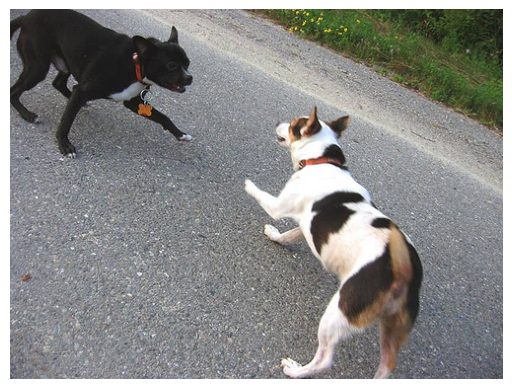

In [25]:
idx = 12
image = mpimg.imread(image_folder / df.image_name[idx])
captions = df.comment[idx]

assert isinstance(captions, list)

for caption in captions:
    print(caption)

plt.axis("off")
plt.imshow(image)
print("")

### Simulate loading of the data for PyTorch

In [44]:
import torch
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/medhyvinceslas/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Sample one caption at random

In [45]:
caption = captions[np.random.randint(0, len(captions))]
caption

'Two dogs on pavement moving toward each other .'

#### standardize

In [46]:
caption_lw = caption.lower()
caption_lw

'two dogs on pavement moving toward each other .'

#### tokenize

In [49]:
tokens = word_tokenize(caption_lw)
tokens

['two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other', '.']

#### reformat

In [50]:
caption_enriched = []
caption_enriched.append('<start>')
caption_enriched.extend([token for token in tokens])
caption_enriched.append('<end>')
caption_enriched

['<start>',
 'two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'toward',
 'each',
 'other',
 '.',
 '<end>']

#### now I need to encode map each words with an integer thanks to the map file created

In [56]:
# import pickle
# with open('../mapping.pkl', 'rb') as f:
#     mapper_file = pickle.load(f)
# mapper_file